# SRGAN (4x)

# Imports

In [1]:
import os
import requests
import zipfile
import sys

In [2]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as trf
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19
from PIL import Image
! pip install piq
from piq import ssim, psnr
import cv2
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 9.3 MB/s eta 0:00:00


In [3]:
import torchvision.transforms as transforms

In [4]:
import matplotlib.pyplot as plt

# Mount Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Dataset

In [6]:
def download_div2k_dataset(base_dir="/content/drive/MyDrive/DIP/DIV2K"):
    """
    Download and extract the DIV2K dataset to the specified directory in Google Drive.
    """
    os.makedirs(base_dir, exist_ok=True)

    # URLs for the DIV2K dataset
    urls = {
        "train_hr": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip",
        "train_lr_bicubic_x2": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip",
        "train_lr_bicubic_x4": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip",
        "valid_hr": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
        "valid_lr_bicubic_x2": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip",
        "valid_lr_bicubic_x4": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip"
    }

    def download_and_extract(url, dir_name):
        # download the file
        response = requests.get(url)
        zip_path = os.path.join(base_dir, f"{dir_name}.zip")

        with open(zip_path, "wb") as f:
            f.write(response.content)

        print(f"Downloaded {dir_name}")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(base_dir)

        print(f"Extracted {dir_name}")

        os.remove(zip_path)
        print(f"Removed {dir_name}.zip")

    for dir_name, url in urls.items():
        print(f"Processing {dir_name}...")
        download_and_extract(url, dir_name)
        print(f"Finished processing {dir_name}")

    print("All datasets have been downloaded and extracted to your Google Drive.")

In [7]:
# download_div2k_dataset()  # run this code to download the DIV2K dataset

# Constants

In [8]:
LR_CROPPED_SIZE = 100
UPSCALE = 4
HR_CROPPED_SIZE = UPSCALE * LR_CROPPED_SIZE
TRAIN_HR_DIR = "/content/drive/MyDrive/DIP/DIV2K/DIV2K_train_HR"
TRAIN_LR_DIR = f"/content/drive/MyDrive/DIP/DIV2K/DIV2K_train_LR_bicubic/X{UPSCALE}"
VAL_HR_DIR = "/content/drive/MyDrive/DIP/DIV2K/DIV2K_valid_HR"
VAL_LR_DIR = f"/content/drive/MyDrive/DIP/DIV2K/DIV2K_valid_LR_bicubic/X{UPSCALE}"
REAL_VALUE = 0.99
FAKE_VALUE = 0.0
BATCH_SIZE = 8
EPOCHS = 50
WARMUP_EPOCHS = 0
N_RESBLK_G = 20
LR = 0.0001
BETAS = (0.5, 0.9)
VGG_LOSS_COEF = 0.006
ADVERSARIAL_LOSS_COEF = 0.001
INTERPOLATION = cv2.INTER_LINEAR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SR_DIR = "/content/drive/MyDrive/DIP/results/sr_img_test"
SR_VAL_DIR = f"/content/drive/MyDrive/DIP/results/sr_val_x{UPSCALE}"
X2_Generator = "/content/drive/MyDrive/DIP/model/G_x2.pt"
PATH_G = "/content/drive/MyDrive/DIP/models_4x/G.pt"
PATH_D = "/content/drive/MyDrive/DIP/models_4x/D.pt"

# Custom Dataset Class

In [9]:
class DIV2K(Dataset):
    def __init__(self, data_dir, transform=trf.ToTensor()):
        pattern = os.path.join(data_dir, "*.png")
        self.file_paths = sorted(glob.glob(pattern))
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_name = os.path.basename(self.file_paths[index])
        img = Image.open(self.file_paths[index])
        img = self.transform(img)

        return img, file_name

# Architecture

## Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.conv_blks = nn.Sequential(
            ConvBlock(64, 64, 2),
            ConvBlock(64, 128, 1),
            ConvBlock(128, 128, 2),
            ConvBlock(128, 256, 1),
            ConvBlock(256, 256, 2),
            ConvBlock(256, 512, 1),
            ConvBlock(512, 512, 2)
        )
        self.global_pooling = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.conv3 = nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=1)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv_blks(X)
        X = self.global_pooling(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = X.flatten(start_dim=1)

        return F.sigmoid(X)

## Convolutional Block

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, strides=1):
        super(ConvBlock, self).__init__()
        self.blk = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, X):
        return self.blk(X)

## Generator

In [12]:
class Generator(nn.Module):
    def __init__(self, n_res_blks, upscale_factor=UPSCALE):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4)
        self.prelu1 = nn.PReLU()
        self.res_blocks = nn.Sequential()
        for i in range(n_res_blks):
            self.res_blocks.add_module(f"res_blk_{i}",
                                       Residual_Block(in_channels=64, out_channels=64, strides=1, use_1x1_conv=False))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.pixel_shufflers = nn.Sequential()
        for i in range(int(np.log2(upscale_factor))):
            self.pixel_shufflers.add_module(f"pixel_shuffle_blk_{i}",
                                            PixelShufflerBlock(in_channels=64, upscale_factor=2))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, padding=4)

    def forward(self, X):
        X = self.prelu1(self.conv1(X))
        X_before_resblks = X.clone()
        X = self.res_blocks(X)
        X = self.bn(self.conv2(X))
        X = F.relu(X + X_before_resblks)
        X = self.pixel_shufflers(X)
        X = self.conv3(X)
        return F.tanh(X)

## Residual Block

In [13]:
class Residual_Block(nn.Module):
    def __init__(self, in_channels, out_channels, strides, use_1x1_conv=True):
        super(Residual_Block, self).__init__()
        self.use_1x1_conv = use_1x1_conv
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        self.blk = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, X):
        X_original = X.clone()
        X = self.blk(X)
        if self.use_1x1_conv:
            X_original = self.conv1x1(X_original)

        return F.relu(X + X_original)

## Shuffle Block

In [14]:
class PixelShufflerBlock(nn.Module):
    def __init__(self, in_channels, upscale_factor=2):
        super(PixelShufflerBlock, self).__init__()
        self.blk = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor=upscale_factor),
            nn.PReLU()
        )

    def forward(self, X):
        return self.blk(X)

## Perceptual Loss

In [15]:
class PerceptualLoss(nn.Module):
    def __init__(self, vgg_coef, adversarial_coef):
        super(PerceptualLoss, self).__init__()
        _vgg19 = vgg19(pretrained=True)
        self.vgg19 = nn.Sequential(*_vgg19.features).eval()
        for p in self.vgg19.parameters():
            p.requires_grad = False
        self.euclidean_distance = nn.MSELoss()
        self.vgg_coef = vgg_coef
        self.adversarial_coef = adversarial_coef

    def forward(self, sr_img, hr_img, output_labels):
        adversarial_loss = torch.mean(1-output_labels)
        vgg_loss = self.euclidean_distance(self.vgg19(sr_img), self.vgg19(hr_img))
        pixel_loss = self.euclidean_distance(sr_img, hr_img)

        return pixel_loss, self.adversarial_coef*adversarial_loss, self.vgg_coef*vgg_loss

# Supplementary Functions

In [16]:
def eval_bilinear():
    psnr_result = []
    ssim_result = []
    lr_imgs = glob(f"{VAL_LR_DIR}/*.png")
    for lr_path in lr_imgs:
        file_name = os.path.basename(lr_path)
        file_name = file_name.replace("x4", '').replace("x2", '')
        hr_path = os.path.join(VAL_HR_DIR, file_name)
        lr = cv2.imread(lr_path)
        hr = cv2.imread(hr_path)

        y = cv2.resize(lr, (lr.shape[1]*UPSCALE, lr.shape[0]*UPSCALE), interpolation=INTERPOLATION)
        h, w = y.shape[:2]
        hr = hr[:h, :w, :]

        psnr_ = PSNR(y, hr)
        ssim_ = SSIM(y, hr, multichannel=True)
        psnr_result.append(psnr_)
        ssim_result.append(ssim_)
        print("psnr", file_name, psnr_)
        print("ssim", file_name, ssim_)

    print("\nMean PSNR:", np.mean(psnr_result))
    print("STD PSNR:", np.std(psnr_result))
    print("Min PSNR:", np.min(psnr_result))
    print("Max PSNR:", np.max(psnr_result))
    print("\nMean SSIM:", np.mean(ssim_result))
    print("STD SSIM:", np.std(ssim_result))
    print("Min SSIM:", np.min(ssim_result))
    print("Max SSIM:", np.max(ssim_result))

In [17]:
def load_img_to_tensor(filepath):
    img = Image.open(filepath)
    return trf.ToTensor()(img)

In [18]:
def eval_PSNR_SSIM():
    psnr_result = torch.tensor([])
    ssim_result = torch.tensor([])
    print("Load SR images from", SR_VAL_DIR)
    sr_vals = glob(f"{SR_VAL_DIR}/*.png")
    for sr_path in sr_vals:
        file_name = os.path.basename(sr_path)
        file_name = file_name.replace("sr_", '').replace("x4", '').replace("x2", '')
        hr_path = os.path.join(VAL_HR_DIR, file_name)
        sr = load_img_to_tensor(sr_path)
        hr = load_img_to_tensor(hr_path)
        psnr_ = psnr(sr.unsqueeze(0), hr.unsqueeze(0), data_range=1.0, reduction='none')
        psnr_result = torch.cat((psnr_result, psnr_))
        print("psnr", file_name, psnr_)
        ssim_ = ssim(sr.unsqueeze(0), hr.unsqueeze(0), data_range=1.0, reduction='none')
        ssim_result = torch.cat((ssim_result, ssim_))
        print("ssim", file_name, ssim_)

    print("\nMean PSNR:", torch.mean(psnr_result))
    print("STD PSNR:", torch.std(psnr_result))
    print("Min PSNR:", torch.min(psnr_result))
    print("Max PSNR:", torch.max(psnr_result))
    print("\nMean SSIM:", torch.mean(ssim_result))
    print("STD SSIM:", torch.std(ssim_result))
    print("Min SSIM:", torch.min(ssim_result))
    print("Max SSIM:", torch.max(ssim_result))

In [19]:
def generate_sr(lr_img_path):
    with torch.no_grad():
        pil_img = Image.open(lr_img_path)
        img_tensor = trf.ToTensor()(pil_img)
        img_tensor = torch.unsqueeze(img_tensor, 0)  # add batch dimension
        img_tensor = img_tensor.to(device)
        sr_img = G(img_tensor)
        print(f"Upscaled from size [{img_tensor.shape[2]}, {img_tensor.shape[3]}] to [{sr_img.shape[2]}, {sr_img.shape[3]}]")
    file_name = os.path.basename(lr_img_path)
    sr_img_path = os.path.join(SR_DIR, f"sr_{file_name}")
    tensor_to_img(sr_img, sr_img_path)

In [20]:
def tensor_to_img(tensor, filepath):
    tensor = tensor.cpu()
    pil = trf.ToPILImage()(tensor.squeeze_(0))
    pil.save(filepath)
    print(f"Saved to {filepath}")

In [21]:
def gen_sr_valset():
    files = glob(f"/content/drive/MyDrive/DIP/DIV2K/DIV2K_valid_LR_bicubic/X{UPSCALE}/*.png")
    for lr_img_path in files:
        with torch.no_grad():
            pil_img = Image.open(lr_img_path)
            img_tensor = trf.ToTensor()(pil_img)
            img_tensor = torch.unsqueeze(img_tensor, 0)  # add batch dimension
            img_tensor = img_

# Training

In [22]:
def load_checkpoints(G, D, optimizerG, optimizerD):
    print("Loading checkpoints ...")
    checkpoint_G = torch.load(PATH_G)
    checkpoint_D = torch.load(PATH_D)
    G.load_state_dict(checkpoint_G['state_dict'])
    optimizerG.load_state_dict(checkpoint_G['optimizer'])
    D.load_state_dict(checkpoint_D['state_dict'])
    optimizerD.load_state_dict(checkpoint_D['optimizer'])
    prev_epochs = checkpoint_G['epoch']

    print("Loaded checkpoints successfully!")
    return G, D, optimizerG, optimizerD, prev_epochs

In [23]:
def save_checkpoints(G, D, optimizer_G, optimizer_D, epoch):
    os.makedirs(os.path.dirname(PATH_G), exist_ok=True)

    checkpoint_G = {
        'model': G,
        'state_dict': G.state_dict(),
        'optimizer': optimizer_G.state_dict(),
        'epoch': epoch
    }
    checkpoint_D = {
        'model': D,
        'state_dict': D.state_dict(),
        'optimizer': optimizer_D.state_dict(),
    }
    torch.save(checkpoint_G, PATH_G)
    torch.save(checkpoint_D, PATH_D)
    print(f"Checkpoints saved for epoch {epoch}")

In [24]:
def xavier_init_weights(model):
    if isinstance(model, nn.Linear) or isinstance(model, nn.Conv2d):
        nn.init.xavier_uniform_(model.weight)

In [25]:
def train(resume_training=True):
    '''
    Train the SRGAN model.

    Params:
      resume_training (bool): whether to continue training from previous checkpoint or not.
                              If checkpoints cannot be found, train from beginning, regardless of resume_training.
    '''
    # load data
    data_train_hr = DIV2K(data_dir=TRAIN_HR_DIR, transform=trf.Compose([
        trf.CenterCrop(HR_CROPPED_SIZE),
        trf.ToTensor()
    ]))
    data_train_lr = DIV2K(data_dir=TRAIN_LR_DIR, transform=trf.Compose([
        trf.CenterCrop(LR_CROPPED_SIZE),
        trf.ToTensor()
    ]))
    hr_train_loader = DataLoader(dataset=data_train_hr, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
    lr_train_loader = DataLoader(dataset=data_train_lr, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
    assert len(hr_train_loader) == len(lr_train_loader)

    # load models
    G = Generator(n_res_blks=N_RESBLK_G, upscale_factor=UPSCALE).to(device)
    D = Discriminator().to(device)
    optimizer_G = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)

    if resume_training and os.path.exists(PATH_G) and os.path.exists(PATH_D):
        G, D, optimizer_G, optimizer_D, prev_epochs = load_checkpoints(G, D, optimizer_G, optimizer_D)
        print("Continue training from previous checkpoints ...")
        warmup = False
    else:
        G.apply(xavier_init_weights)
        D.apply(xavier_init_weights)
        prev_epochs = 0
        print("Training from start ...")
        warmup = True

    # train
    G.train()
    D.train()

    criterion_G = PerceptualLoss(vgg_coef=VGG_LOSS_COEF, adversarial_coef=ADVERSARIAL_LOSS_COEF).to(device)
    warmup_loss = nn.L1Loss()
    criterion_D = nn.BCELoss()

    # warm up G
    if warmup:
        for w in range(WARMUP_EPOCHS):
            print(f"\nWarmup: {w+1}")
            for (batch, hr_batch), lr_batch in zip(enumerate(hr_train_loader), lr_train_loader):
                hr_img, lr_img = hr_batch[0].to(device), lr_batch[0].to(device)
                optimizer_G.zero_grad()

                sr_img = G(lr_img)
                err_G = warmup_loss(sr_img, hr_img)
                err_G.backward()

                optimizer_G.step()
                if batch % 10 == 0:
                    print(f"\tBatch: {batch + 1}/{len(data_train_hr) // BATCH_SIZE}")
                    print(f"\tMAE G: {err_G.item():.4f}")

    for e in range(EPOCHS):
        print(f"\nEpoch: {e+prev_epochs+1}")

        for (batch, hr_batch), lr_batch in zip(enumerate(hr_train_loader), lr_train_loader):
            hr_img, lr_img = hr_batch[0].to(device), lr_batch[0].to(device)

            # train D: maximize log(D(x)) + log(1-D(G(z)))
            optimizer_D.zero_grad()

            real_labels = torch.full(size=(len(hr_img),), fill_value=REAL_VALUE, dtype=torch.float, device=device)
            output_real = D(hr_img).view(-1)
            err_D_real = criterion_D(output_real, real_labels)
            err_D_real.backward()

            fake_labels = torch.full(size=(len(hr_img),), fill_value=FAKE_VALUE, dtype=torch.float, device=device)
            sr_img = G(lr_img)
            output_fake = D(sr_img.detach()).view(-1)
            err_D_fake = criterion_D(output_fake, fake_labels)
            err_D_fake.backward()

            optimizer_D.step()
            D_Gz1 = output_fake.mean().item()

            # train G: minimize log(D(G(z))
            optimizer_G.zero_grad()

            output_fake = D(sr_img).view(-1)
            pixel_loss, adversarial_loss, vgg_loss = criterion_G(sr_img, hr_img, output_fake)
            err_G = pixel_loss + adversarial_loss + vgg_loss
            err_G.backward()

            optimizer_G.step()

            # print stats
            if batch%10==0:
                print(f"\tBatch: {batch + 1}/{len(data_train_hr) // BATCH_SIZE}")
                D_x = output_real.mean().item()
                D_Gz2 = output_fake.mean().item()
                print(f"\terr_D_real: {err_D_real.item():.4f}; err_D_fake: {err_D_fake.item():.4f}; "
                      f" err_G: {err_G.item():.4f}; D_x: {D_x:.4f}; D_Gz1: {D_Gz1:.4f}; D_Gz2: {D_Gz2:.4f}")
                print(f"\t adversarial_loss: {adversarial_loss:.4f}, vgg_loss: {vgg_loss:.4f}, "
                      f"pixel_loss: {pixel_loss:.4f}")

            # free up GPU memory
            del hr_img, lr_img, err_D_fake, err_D_real, err_G, real_labels, fake_labels, \
                output_real, output_fake, sr_img, pixel_loss, adversarial_loss, vgg_loss
            torch.cuda.empty_cache()

        # save checkpoints
        save_checkpoints(G, D, optimizer_G, optimizer_D, epoch=prev_epochs+e+1)

In [26]:
train(resume_training=True)

Loading checkpoints ...


<ipython-input-22-d5c63ffbaa68>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_G = torch.load(PATH_G)
<ipython-input-22-d5c63ffbaa68>:4: FutureWarning: You are 

Loaded checkpoints successfully!
Continue training from previous checkpoints ...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 73.6MB/s]



Epoch: 46
	Batch: 1/100
	err_D_real: 0.0563; err_D_fake: 0.0000;  err_G: 0.0059; D_x: 0.9877; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0007, pixel_loss: 0.0042
	Batch: 11/100
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0065; D_x: 0.9895; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0012, pixel_loss: 0.0043
	Batch: 21/100
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0062; D_x: 0.9900; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0008, pixel_loss: 0.0044
	Batch: 31/100
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0083; D_x: 0.9903; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0016, pixel_loss: 0.0057
	Batch: 41/100
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0076; D_x: 0.9908; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0010, pixel_loss: 0.0057
	Batch: 51/100
	err_D_real: 0.0560; err_D_fake: 0.0000;  err_G: 0.0057; D_x: 0.9894; D_Gz1: 0.0

KeyboardInterrupt: 

# Upscaling Function

In [27]:
def upscale_image(input_image_path, output_image_path, model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load the trained generator model
    G = Generator(n_res_blks=N_RESBLK_G, upscale_factor=UPSCALE).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    G.load_state_dict(checkpoint['state_dict'])
    G.eval()

    img = Image.open(input_image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_tensor = G(input_tensor)

    sr_img = transforms.ToPILImage()(sr_tensor.squeeze(0).cpu())
    sr_img.save(output_image_path)
    print(f"Super-resolution image saved to {output_image_path}")

    # get shapes of LR and SR images
    lr_shape = img.size  # (width, height)
    sr_shape = sr_img.size  # (width, height)

    return img, sr_img, lr_shape, sr_shape

In [28]:
input_image_path = "quartlenna.png"
output_image_path = "sr_queartlenna.png"
model_path = "/content/drive/MyDrive/DIP/models_4x/G.pt"

In [30]:
lr_img, sr_img, lr_shape, sr_shape = upscale_image(input_image_path, output_image_path, model_path)

<ipython-input-27-1e8f9bb7e083>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Super-resolution image saved to sr_queartlenna.png


# Image Comparison

In [32]:
def display_images(img1, img2, title1="Original", title2="Super-Resolved"):
    plt.figure(figsize=(20,10))

    plt.subplot(121)
    plt.imshow(img1)
    plt.title(f"{title1} - {img1.size[0]}x{img1.size[1]}")
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(img2)
    plt.title(f"{title2} - {img2.size[0]}x{img2.size[1]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

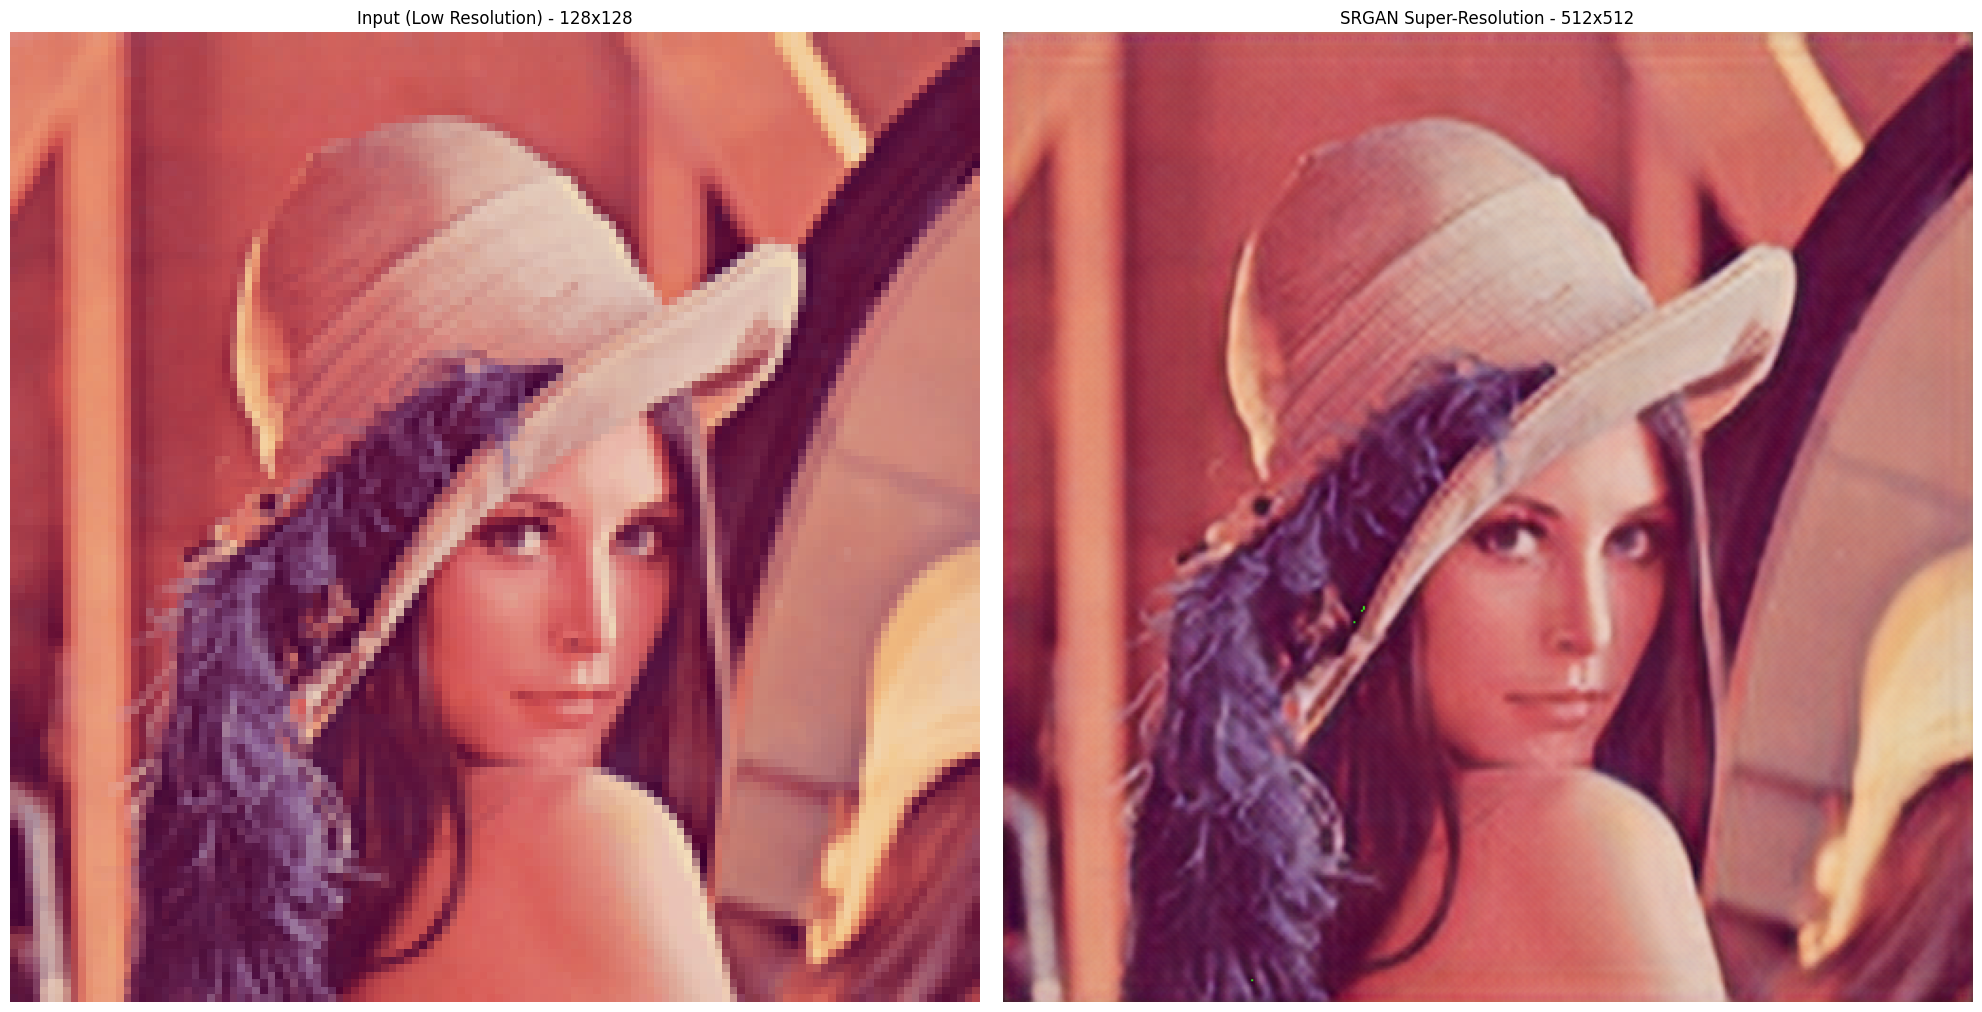

In [33]:
display_images(lr_img, sr_img, "Input (Low Resolution)", "SRGAN Super-Resolution")

In [34]:
input_image_path = "quartzebra.png"
output_image_path = "sr_quartzebra.png"
model_path = "/content/drive/MyDrive/DIP/models_4x/G.pt"

In [35]:
lr_img, sr_img, lr_shape, sr_shape = upscale_image(input_image_path, output_image_path, model_path)

<ipython-input-27-1e8f9bb7e083>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Super-resolution image saved to sr_quartzebra.png


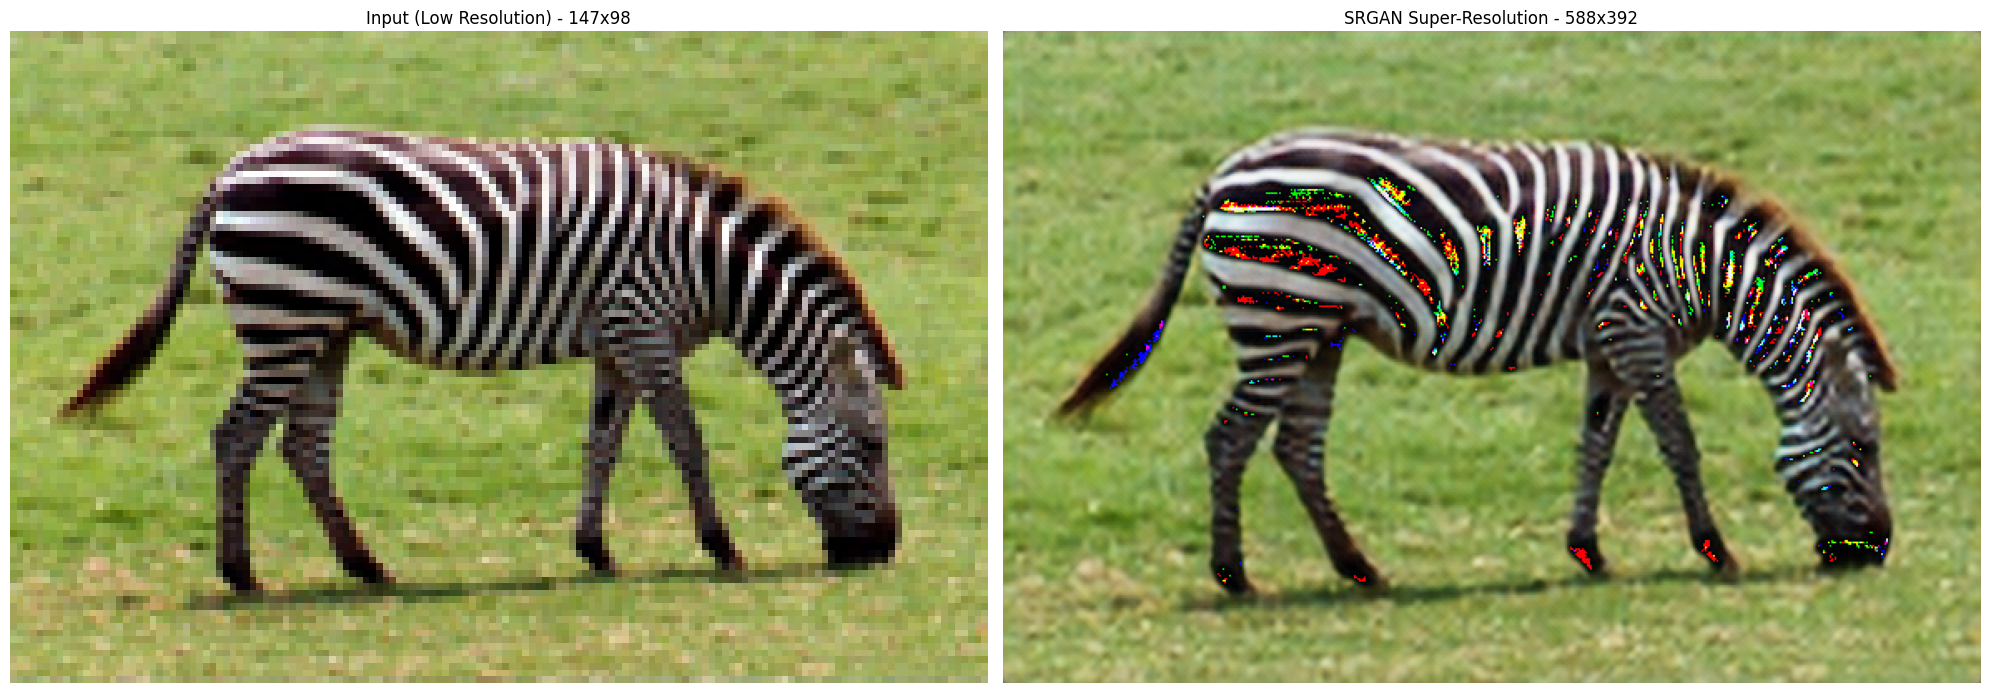

In [36]:
display_images(lr_img, sr_img, "Input (Low Resolution)", "SRGAN Super-Resolution")

In [37]:
input_image_path = "quartcomic.png"
output_image_path = "sr_quartcomic.png"
model_path = "/content/drive/MyDrive/DIP/models_4x/G.pt"

In [38]:
lr_img, sr_img, lr_shape, sr_shape = upscale_image(input_image_path, output_image_path, model_path)

<ipython-input-27-1e8f9bb7e083>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Super-resolution image saved to sr_quartcomic.png


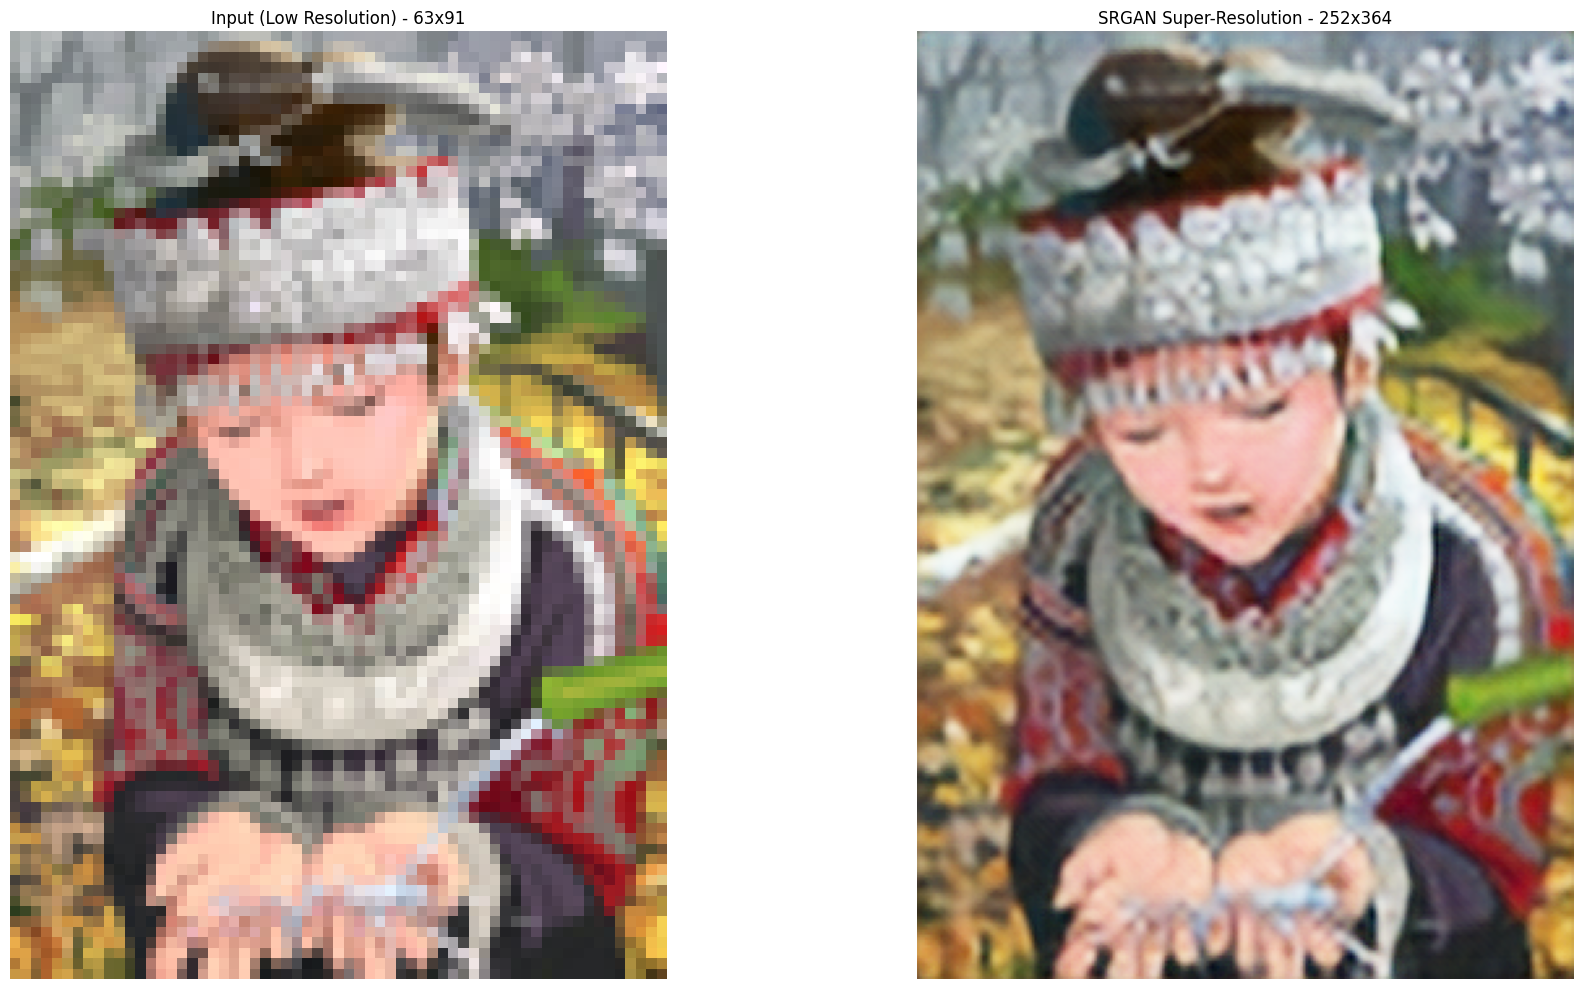

In [39]:
display_images(lr_img, sr_img, "Input (Low Resolution)", "SRGAN Super-Resolution")

# Conclusion

**SRGAN 4x** results are really better than the ones from **SRCNN 4x** and **EDSR 4x**. However, *edge artifacts* are still observed on the high contrast regions of the image.